In [4]:
import pandas as pd
import psycopg2 as pg
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
engine = pg.connect("dbname='safeidx' user='fbk_mpba' host='172.104.247.67' port='5432' password='fbk2024$'")
df = pd.read_sql('select * from data_safeidx', con=engine)

/tmp/ipykernel_42878/2472232159.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql('select * from data_safeidx', con=engine)


In [6]:
df.head()

difficulty             cause     town province gender equipment helmet  \
0     novice        fall_alone   SIKLOS               F       ski   None   
1   advanced        fall_alone    MALMO               M       ski   None   
2   advanced        fall_alone  CALDARO       BZ      F       ski   None   
3   advanced  collision_person     LINZ               M       ski   None   
4   advanced  collision_person   RUSAVA               M       ski   None   

               destination   diagnosis india   age          country  \
0  hospital_emergency_room  distortion  None  32.0         Ungheria   
1  hospital_emergency_room      bruise  None  32.0           Svezia   
2                 domicile       other  None  12.0           Italia   
3  hospital_emergency_room      bruise  None  58.0          Austria   
4                    other      bruise  None  25.0  Repubblica Ceca   

  injury_side injury_general_location evacuation_vehicles  
0           L             lower_limbs              [akja]  
1           R           skull_or_face              [akja]  
2           R                    None        [snowmobile]  
3           R             lower_limbs        [snowmobile]  
4           L             lower_limbs             [other]

In [99]:
ev = set({})
for i,row in df.iterrows():
    ev = ev.union(set(row.evacuation_vehicles))

AttributeError: 'Series' object has no attribute 'evacuation_vehicles'

In [8]:
for c in ev:
    df[c] = False
for i,row in df.iterrows():
    for c in row.evacuation_vehicles:
        df.loc[i,c] = True

In [9]:
df.drop(columns=['town','province','evacuation_vehicles'],inplace=True)

(array([1.3808e+04, 0.0000e+00, 8.8100e+02, 0.0000e+00, 0.0000e+00,
        3.3690e+03, 0.0000e+00, 1.5200e+02, 0.0000e+00, 1.1000e+01]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

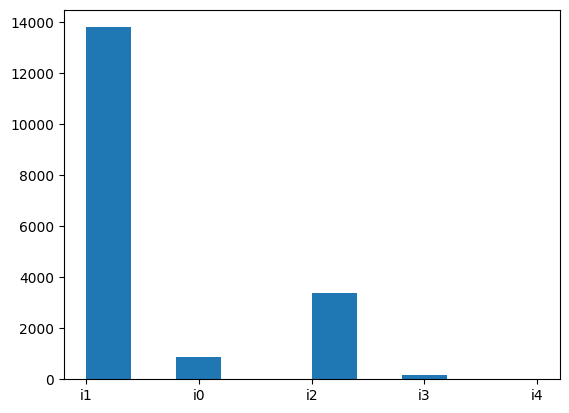

In [100]:
labeled = df[~pd.isna(df.india)]
plt.hist(labeled.india)

/tmp/ipykernel_42878/2289208715.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled['is_i1']=0


(array([ 3532.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 14689.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

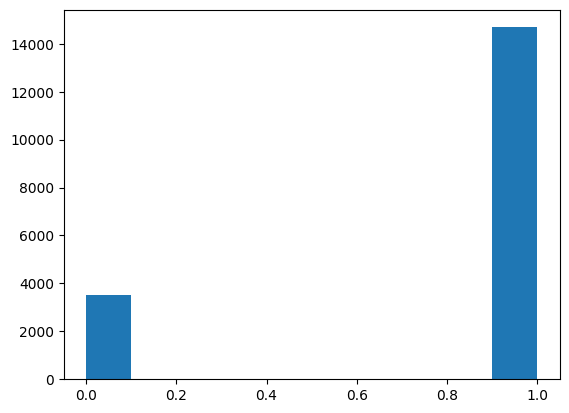

In [101]:
labeled['is_i1']=0
labeled.loc[labeled.india.isin(['i1','i0']),'is_i1']=1
plt.hist(labeled.is_i1)

In [103]:
labeled[c] =  labeled[c].astype(np.float32).fillna(np.nan)
for c in labeled.columns:
    if c!='age':
        labeled[c] =  labeled[c].fillna('None').astype('category')


/tmp/ipykernel_42878/1116779111.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled[c] =  labeled[c].astype(np.float32).fillna(np.nan)
/tmp/ipykernel_42878/1116779111.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled[c] =  labeled[c].fillna('None').astype('category')
/tmp/ipykernel_42878/1116779111.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [104]:
X_train, X_test, y_train, y_test = train_test_split( labeled.drop(columns=['india','is_i1']),
                                                    labeled.is_i1, test_size=0.33, random_state=0,stratify=labeled.is_i1)

In [105]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=0.33, random_state=0,stratify=y_train)

In [147]:
weight_train = (1-y_train.values.astype(int))*5+1 ## peso classi unbalanced

In [148]:
weight_train

array([6, 6, 1, ..., 1, 1, 1])

In [149]:
from catboost import CatBoostClassifier, Pool

train_data = Pool(data=X_train,
                  label=y_train,
                  weight=weight_train,cat_features=[c for c in X_train.columns if c!='age'])
valid_data = Pool(data=X_valid,
                  label=y_valid,cat_features=[c for c in X_train.columns if c!='age']
                  )
model = CatBoostClassifier(iterations=1000)

model.fit(train_data,eval_set=valid_data,verbose=False,early_stopping_rounds=100)
preds_class = model.predict(valid_data,)

In [150]:
preds_class_valid = model.predict(valid_data)
preds_class_train= model.predict(train_data)

In [151]:
from sklearn.metrics import confusion_matrix,matthews_corrcoef,accuracy_score

In [152]:
print(confusion_matrix(y_valid,preds_class_valid))
print(matthews_corrcoef(y_valid,preds_class_valid))
print(accuracy_score(y_valid,preds_class_valid))
print('########################################')
print(confusion_matrix(y_train,preds_class_train))
print(matthews_corrcoef(y_train,preds_class_train))
print(accuracy_score(y_train,preds_class_train))

[[ 622  159]
 [ 778 2470]]
0.4623150659581546
0.7674360883593944
########################################
[[1436  149]
 [1358 5236]]
0.5834604503367398
0.8157476464115417


In [157]:
##try with xgboost
import xgboost as xgb

# Create regression matrices
dtrain = xgb.DMatrix(X_train, y_train.astype(int), enable_categorical=True)#,weight=weight_train)
dvalid = xgb.DMatrix(X_valid, y_valid.astype(int), enable_categorical=True)

TypeError: DMatrix.__init__() got an unexpected keyword argument 'scale_pos_weight'

In [154]:
params = {"objective": "multi:softprob", "num_class": 2}
n = 1000

results = xgb.train(
   params, dtrain,
   num_boost_round=n,
  evals = [(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=False,
    early_stopping_rounds=100
  # metrics=["mlogloss", "auc", "merror"],
)


In [155]:
preds_class_valid = results.predict(dvalid)
preds_class_train= results.predict(dtrain)

In [156]:
print(confusion_matrix(y_valid,preds_class_valid.argmax(1)))
print(matthews_corrcoef(y_valid,preds_class_valid.argmax(1)))
print(accuracy_score(y_valid,preds_class_valid.argmax(1)))
print('########################################')
print(confusion_matrix(y_train,preds_class_train.argmax(1)))
print(matthews_corrcoef(y_train,preds_class_train.argmax(1)))
print(accuracy_score(y_train,preds_class_train.argmax(1)))

[[ 492  289]
 [ 471 2777]]
0.4495009568013873
0.811367585008687
########################################
[[1584    1]
 [ 389 6205]]
0.8688028589259579
0.9523169091575987
